# 1. Loading Data and Packages


In [344]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import warnings
import xgboost as xgb
import lightgbm as lgb
from scipy.stats import skew
from scipy import stats
from scipy.stats.stats import pearsonr
from scipy.stats import norm
from collections import Counter
from sklearn.linear_model import LinearRegression,LassoCV, Ridge, LassoLarsCV,ElasticNetCV
from sklearn.model_selection import GridSearchCV, cross_val_score, learning_curve
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, Normalizer, RobustScaler
from sklearn.model_selection import train_test_split
warnings.filterwarnings('ignore')
sns.set(style='white', context='notebook', palette='deep')
%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline

In [345]:
df = pd.read_csv("resale-flat-prices-based-on-registration-date-from-jan-2017-onwards.csv")

In [346]:
df['month'] = pd.to_datetime(df['month'])
df['Year'] = df['month'].apply(lambda x: x.year)
df['Month'] = df['month'].apply(lambda x: x.month)

In [347]:
df['remaining_years'] = df['Year']-df['lease_commence_date']
df['flat_type_model'] = df['flat_type']+' '+df['flat_model']
df.drop(columns = ['flat_type','flat_model'])
df.head()
df = df[df['Year'] == 2018]

In [348]:
df = df.drop(columns = ['month','remaining_lease','lease_commence_date'])

In [349]:
x = df
y = df['flat_type']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.5,
random_state = 1, stratify = y)
train = x_train
test = x_test

In [350]:
train['Id'] = [i for i in range(len(x_train))]
test['Id'] =[i for i in range(len(x_test))]
# why do i care about the town or block if I know the town and storey range?
# people look at street_name/location and which storey when buying house
train = train.drop(columns = ['Year','block','town','flat_model'])
test = test.drop(columns = ['Year','block','town','flat_model'])

In [351]:
train.head()

,flat_type,street_name,storey_range,floor_area_sqm,resale_price,Month,remaining_years,flat_type_model,Id
36899,3 ROOM,BEDOK NTH ST 3,04 TO 06,68.0,270000.0,10,39,3 ROOM New Generation,0
35867,5 ROOM,PASIR RIS ST 71,07 TO 09,125.0,500000.0,9,22,5 ROOM Improved,1
32352,3 ROOM,POTONG PASIR AVE 1,04 TO 06,83.0,423000.0,7,34,3 ROOM Model A,2
23972,4 ROOM,STIRLING RD,10 TO 12,95.0,605000.0,3,18,4 ROOM Model A,3
28569,3 ROOM,EVERTON PK,04 TO 06,72.0,420000.0,6,38,3 ROOM New Generation,4


In [352]:
test.head()

,flat_type,street_name,storey_range,floor_area_sqm,resale_price,Month,remaining_years,flat_type_model,Id
37540,3 ROOM,JURONG EAST ST 24,01 TO 03,67.0,220000.0,10,35,3 ROOM New Generation,0
36309,4 ROOM,SERANGOON NTH AVE 1,10 TO 12,91.0,335000.0,9,33,4 ROOM New Generation,1
37889,4 ROOM,PUNGGOL DR,04 TO 06,93.0,455000.0,10,5,4 ROOM Premium Apartment,2
40770,4 ROOM,BEDOK RESERVOIR RD,01 TO 03,104.0,450000.0,12,34,4 ROOM Model A,3
37615,4 ROOM,BOON LAY DR,10 TO 12,111.0,408000.0,10,23,4 ROOM Model A,4


In [353]:
# Check the numbers of samples and features
print("The train data size before dropping Id feature is : {} ".format(train.shape))
print("The test data size before dropping Id feature is : {} ".format(test.shape))

# Save the 'Id' column
train_ID = train['Id']
test_ID = test['Id']

# Now drop the 'Id' column since it's unnecessary for the prediction process.
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

# Check data size after dropping the 'Id' variable
print("\nThe train data size after dropping Id feature is : {} ".format(train.shape)) 
print("The test data size after dropping Id feature is : {} ".format(test.shape))

The train data size before dropping Id feature is : (10780, 9) 
The test data size before dropping Id feature is : (10781, 9) 

The train data size after dropping Id feature is : (10780, 8) 
The test data size after dropping Id feature is : (10781, 8) 


# 2. Analyzing the Test Variable (Sale Price)


In [354]:
train['resale_price'].describe()


count    1.078000e+04
mean     4.409328e+05
std      1.573940e+05
min      1.680000e+05
25%      3.280000e+05
50%      4.089440e+05
75%      5.150000e+05
max      1.168000e+06
Name: resale_price, dtype: float64


 mu = 440932.80 and sigma = 157386.74



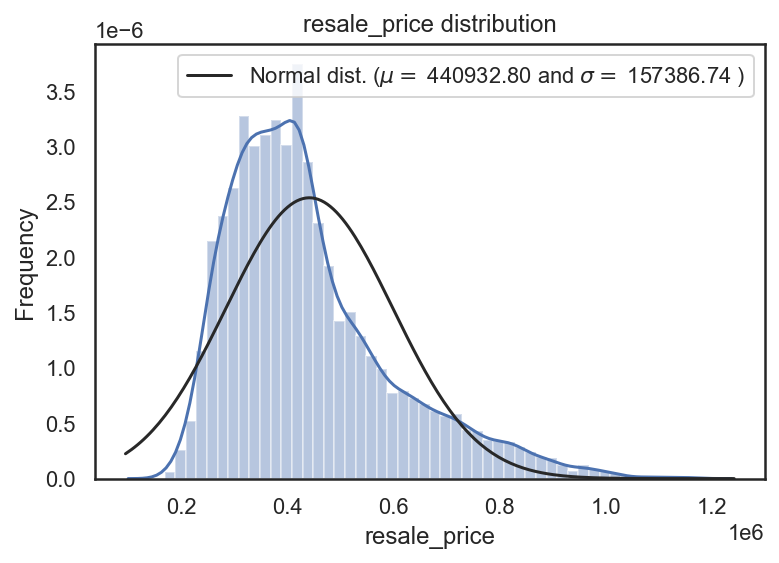

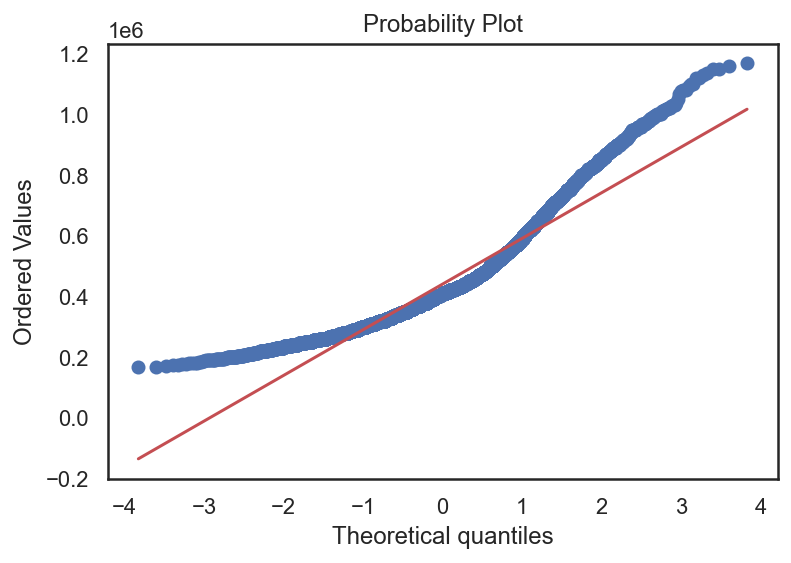

Skewness: 1.176825
Kurtosis: 1.314864


In [355]:
# Plot Histogram
sns.distplot(train['resale_price'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['resale_price'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('resale_price distribution')

fig = plt.figure()
res = stats.probplot(train['resale_price'], plot=plt)
plt.show()

print("Skewness: %f" % train['resale_price'].skew())
print("Kurtosis: %f" % train['resale_price'].kurt())

# 3. Multivariable Analysis

In [356]:
# Checking Categorical Data
train.select_dtypes(include=['object']).columns

Index(['flat_type', 'street_name', 'storey_range', 'flat_type_model'], dtype='object')

In [357]:
# Checking Numerical Data
train.select_dtypes(include=['int64','float64']).columns

Index(['floor_area_sqm', 'resale_price', 'Month', 'remaining_years'], dtype='object')

In [358]:
cat = len(train.select_dtypes(include=['object']).columns)
num = len(train.select_dtypes(include=['int64','float64']).columns)
print('Total Features: ', cat, 'categorical', '+',
      num, 'numerical', '=', cat+num, 'features')

Total Features:  4 categorical + 4 numerical = 8 features


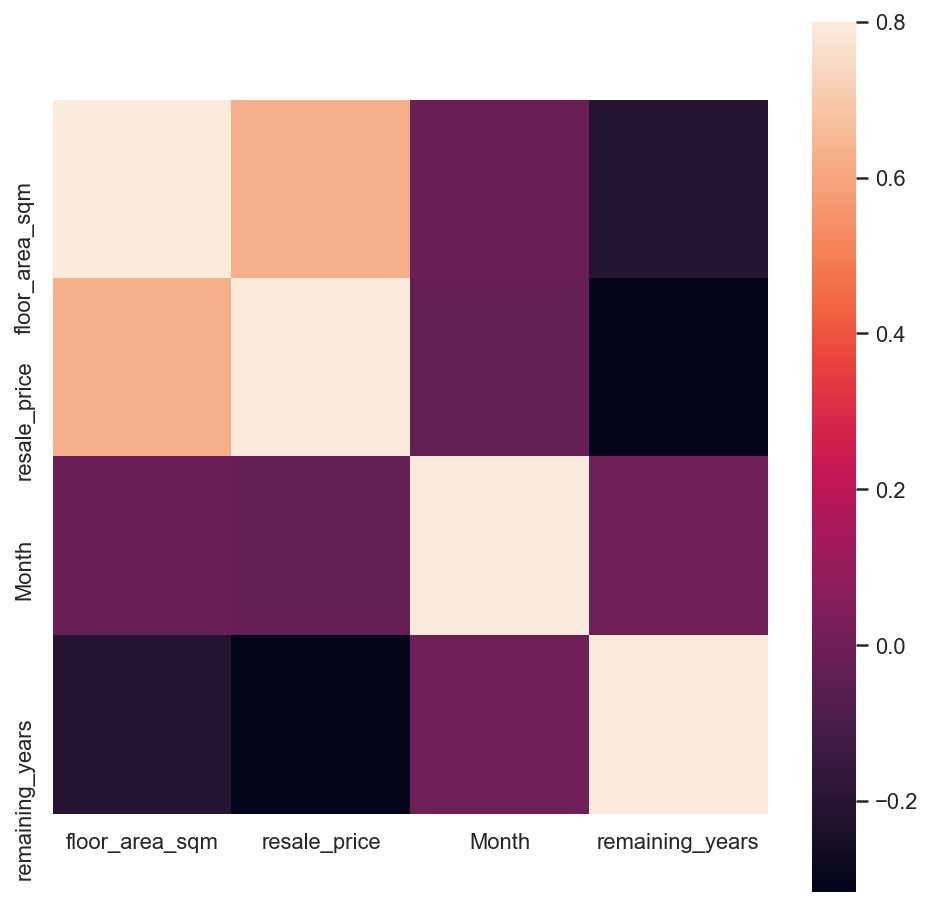

In [359]:
# Correlation Matrix Heatmap
corrmat = train.corr()
f, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(corrmat, vmax=.8, square=True);

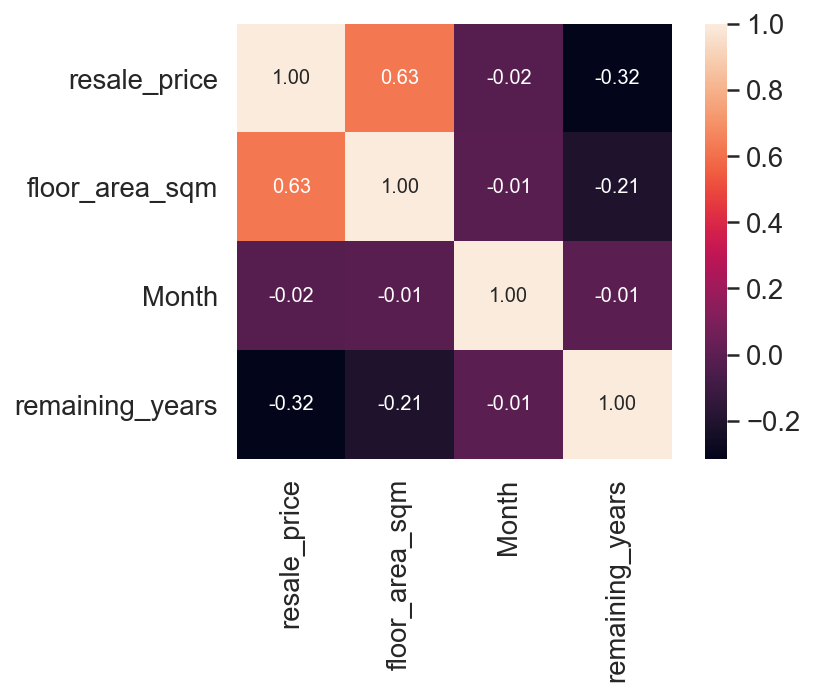

In [360]:
# Top 10 Heatmap
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'resale_price')['resale_price'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [361]:
most_corr = pd.DataFrame(cols)
most_corr.columns = ['Most Correlated Features']
most_corr

,Most Correlated Features
0,resale_price
1,floor_area_sqm
2,Month
3,remaining_years


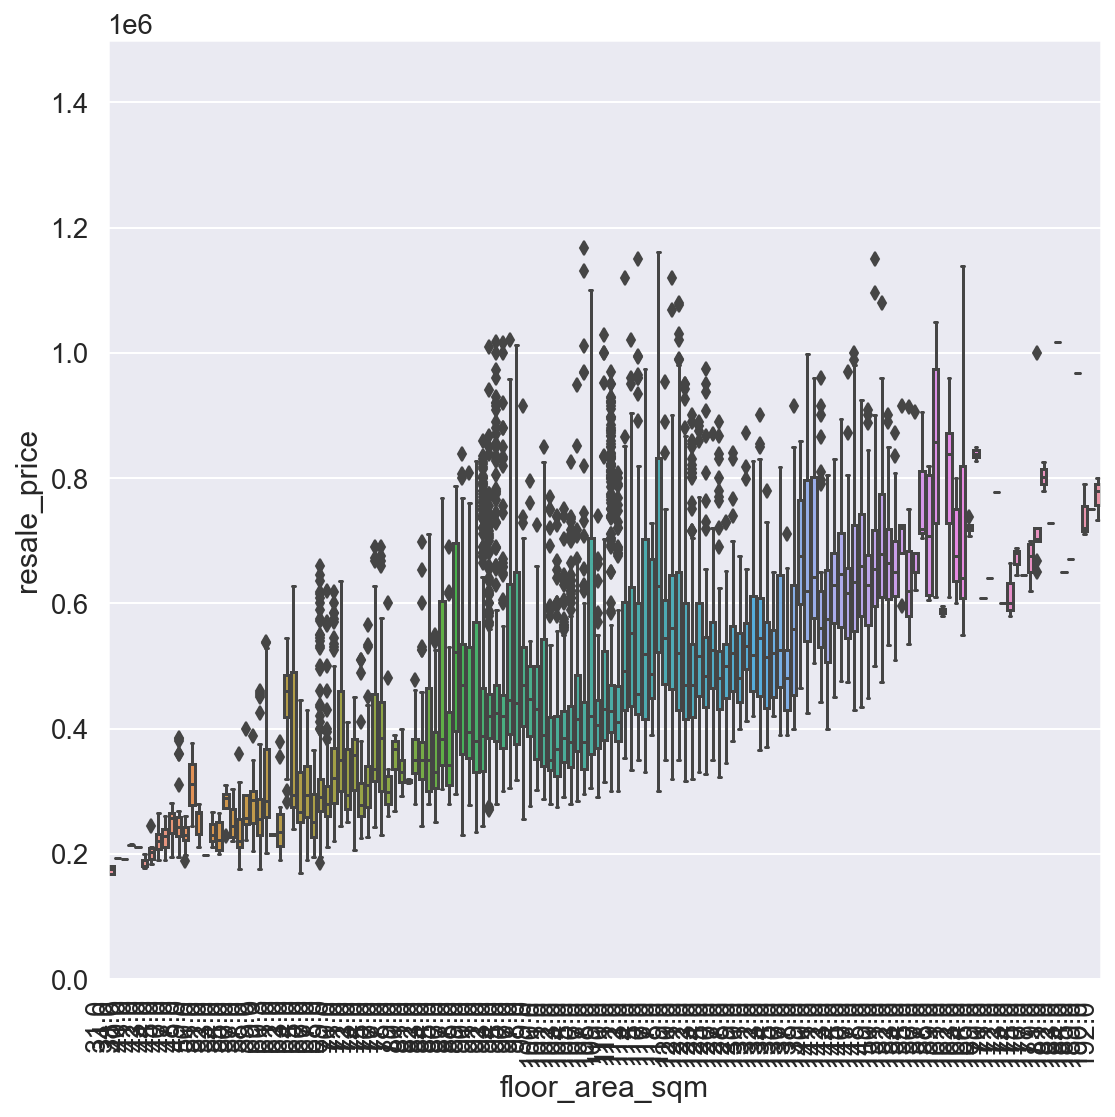

In [362]:
#  floor_area_sqm vs resale_price
var = 'floor_area_sqm'
data = pd.concat([train['resale_price'], train[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 8))
fig = sns.boxplot(x=var, y="resale_price", data=data)
fig.axis(ymin=0, ymax=1500000);
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
plt.tight_layout()
plt.show()

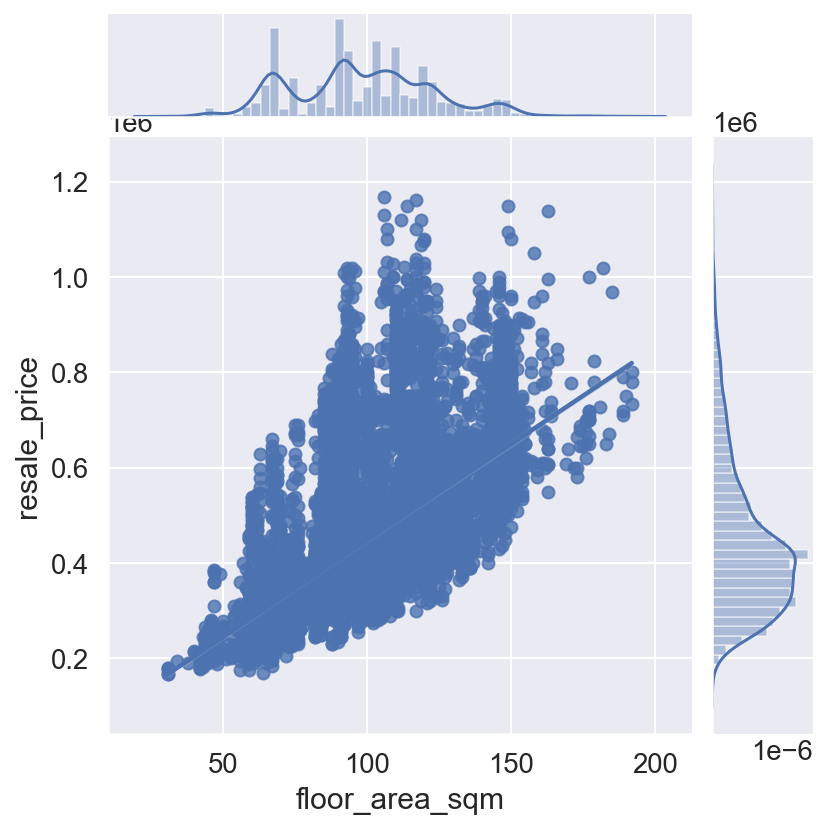

In [363]:
#  floor_area_sqm vs resale_price
sns.jointplot(x=train['floor_area_sqm'], y=train['resale_price'], kind='reg')

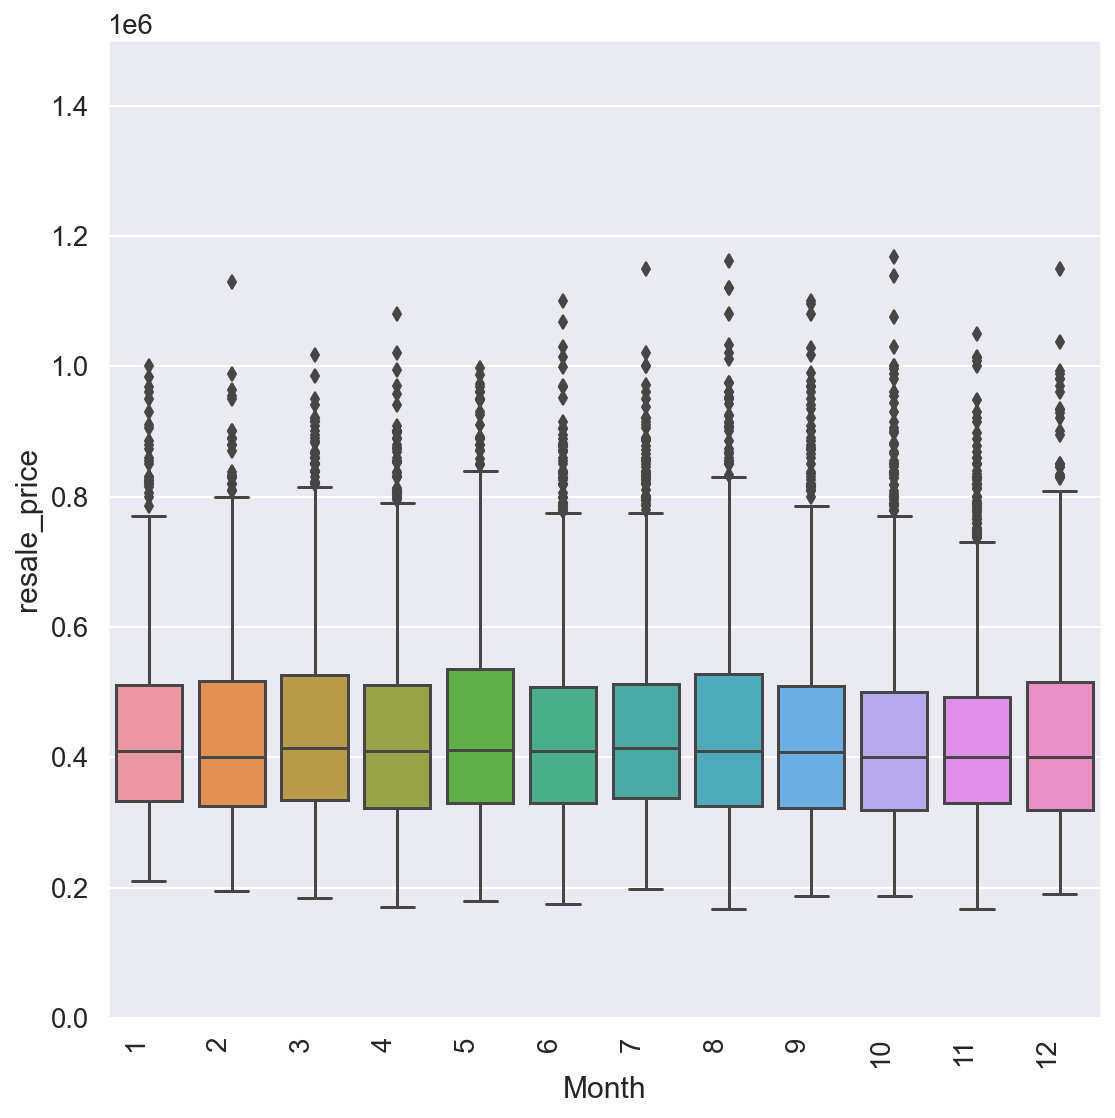

In [364]:
#  Month vs resale_price
var = 'Month'
data = pd.concat([train['resale_price'], train[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 8))
fig = sns.boxplot(x=var, y="resale_price", data=data)
fig.axis(ymin=0, ymax=1500000);
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
plt.tight_layout()
plt.show()

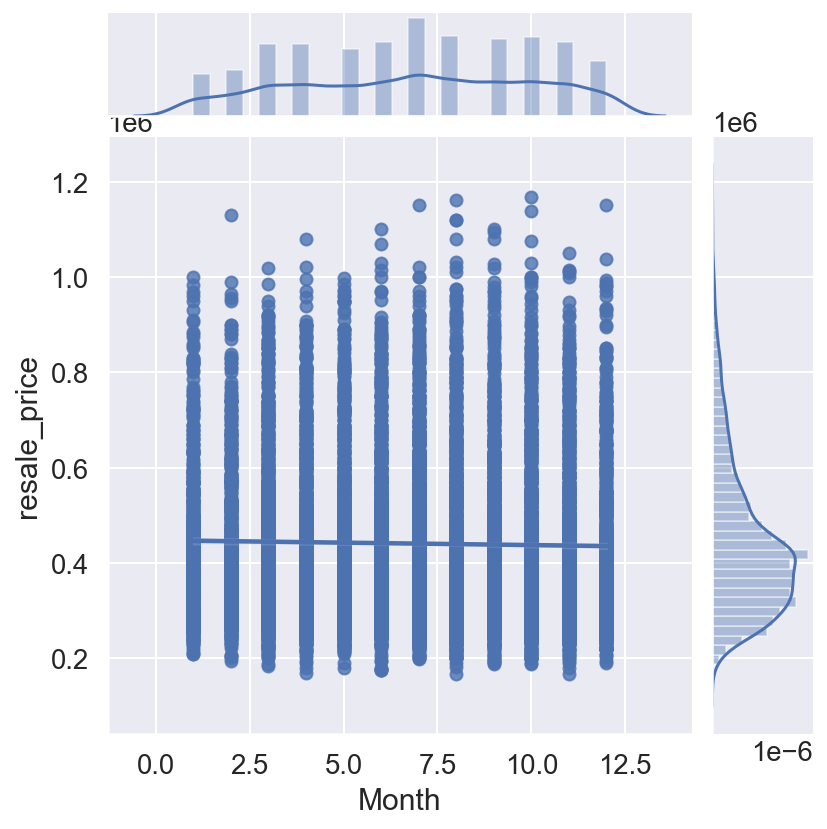

In [365]:
#  Month vs resale_price
sns.jointplot(x=train['Month'], y=train['resale_price'], kind='reg')

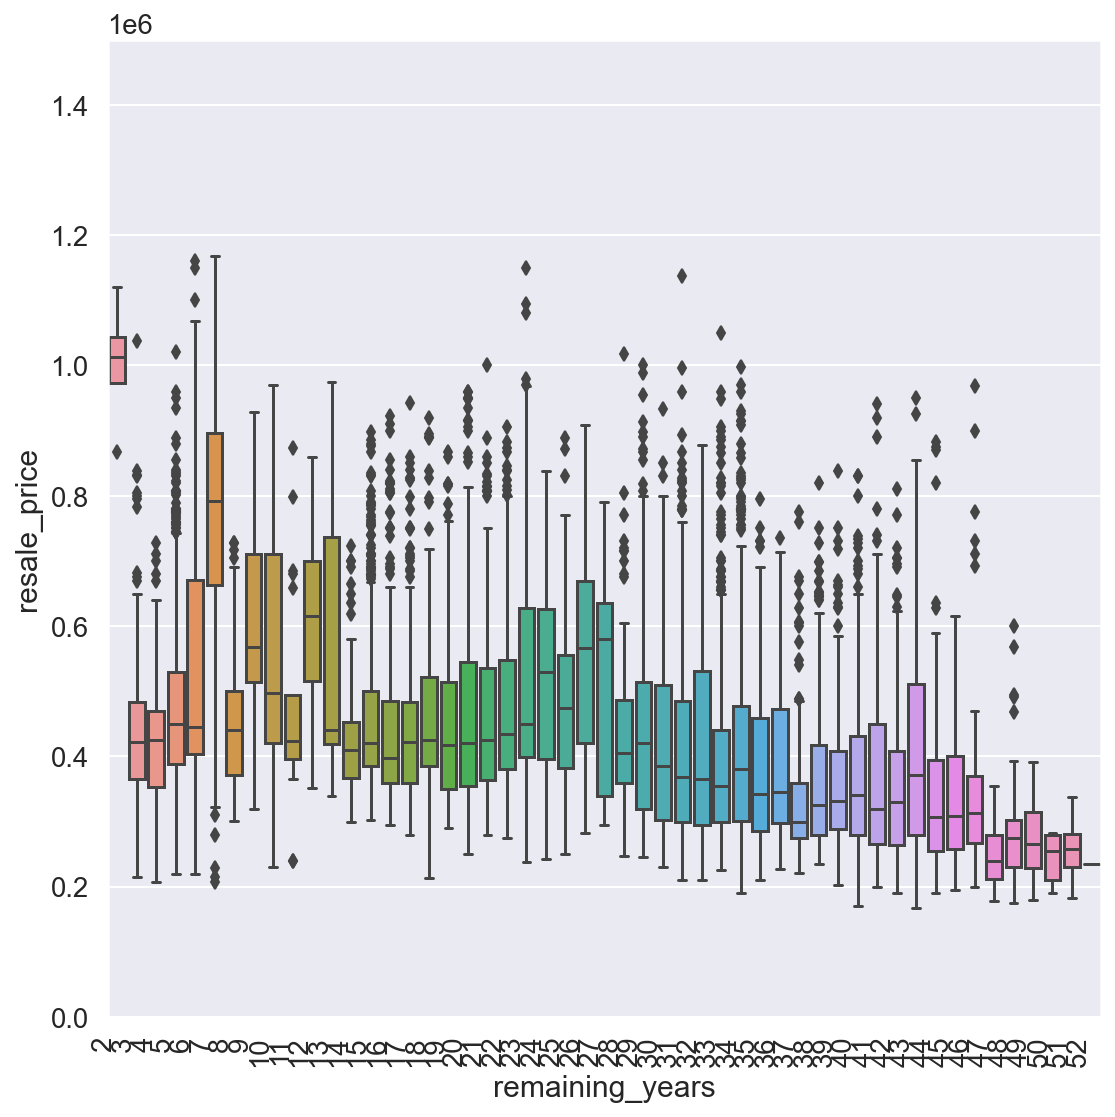

In [366]:
#  remaining_years vs resale_price
var = 'remaining_years'
data = pd.concat([train['resale_price'], train[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 8))
fig = sns.boxplot(x=var, y="resale_price", data=data)
fig.axis(ymin=0, ymax=1500000);
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
plt.tight_layout()
plt.show()

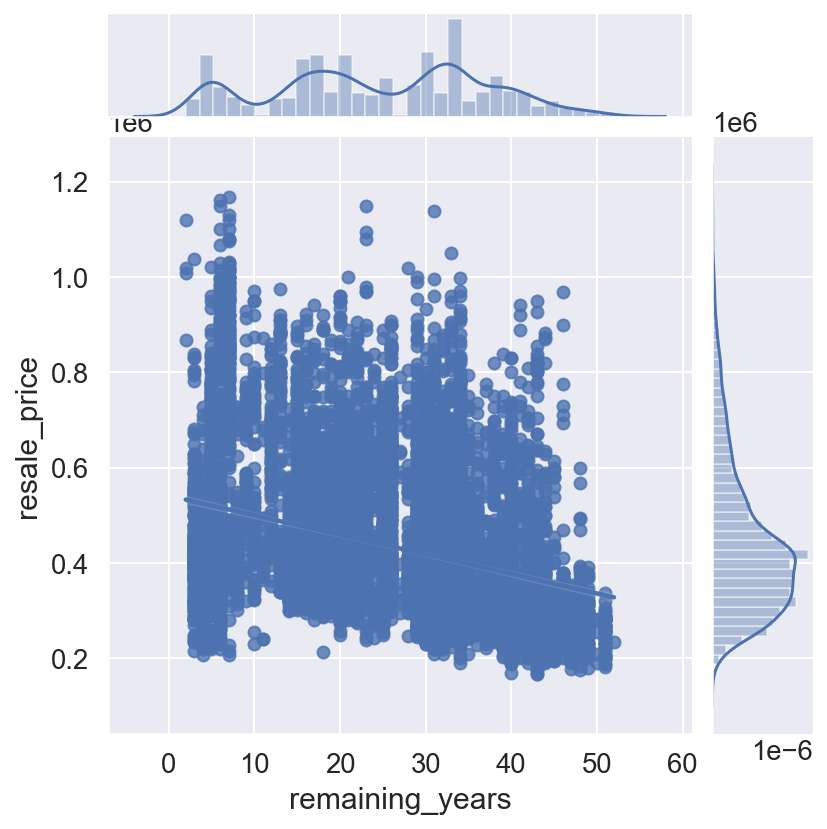

In [367]:
#  remaining_years vs resale_price
sns.jointplot(x=train['remaining_years'], y=train['resale_price'], kind='reg')

# Impute Missing Data and Clean Data

In [368]:
# Combining Datasets
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.resale_price.values
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['resale_price'], axis=1, inplace=True)
print("Train data size is : {}".format(train.shape))
print("Test data size is : {}".format(test.shape))
print("Combined dataset size is : {}".format(all_data.shape))

Train data size is : (10780, 8)
Test data size is : (10781, 8)
Combined dataset size is : (21561, 7)


In [369]:
# Find Missing Ratio of Dataset
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data

,Missing Ratio


# Feature Transformation/Engineering


In [370]:
all_data['flat_type_model'].describe()

count              21561
unique                40
top       4 ROOM Model A
freq                5126
Name: flat_type_model, dtype: object

In [371]:
from sklearn.preprocessing import LabelEncoder
# Process columns and apply LabelEncoder to categorical features
lbl = LabelEncoder() 
lbl.fit(list(all_data['storey_range'].values)) 
all_data['storey_range'] = lbl.transform(list(all_data['storey_range'].values))

# Check shape        
print('Shape all_data: {}'.format(all_data.shape))

Shape all_data: (21561, 7)


In [373]:
all_data.head()

,flat_type,street_name,storey_range,floor_area_sqm,Month,remaining_years,flat_type_model
0,3 ROOM,BEDOK NTH ST 3,1,68.0,10,39,3 ROOM New Generation
1,5 ROOM,PASIR RIS ST 71,2,125.0,9,22,5 ROOM Improved
2,3 ROOM,POTONG PASIR AVE 1,1,83.0,7,34,3 ROOM Model A
3,4 ROOM,STIRLING RD,3,95.0,3,18,4 ROOM Model A
4,3 ROOM,EVERTON PK,1,72.0,6,38,3 ROOM New Generation



 mu = 12.94 and sigma = 0.33



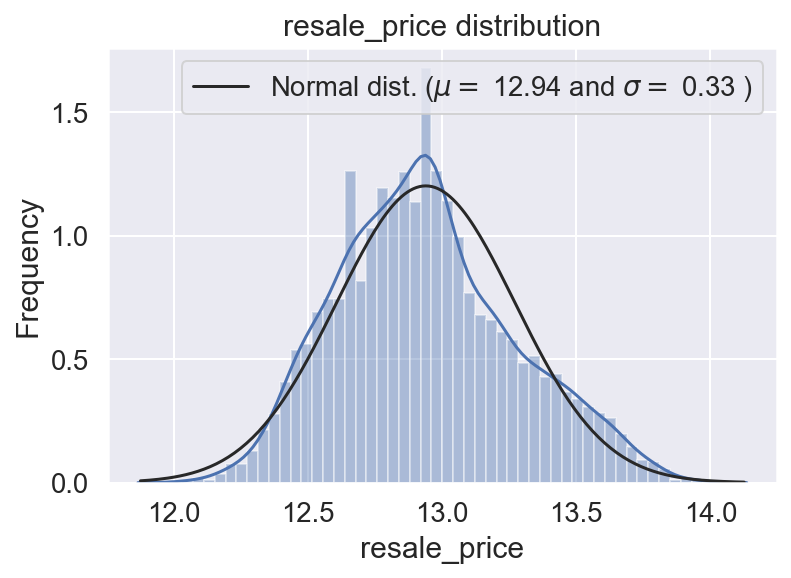

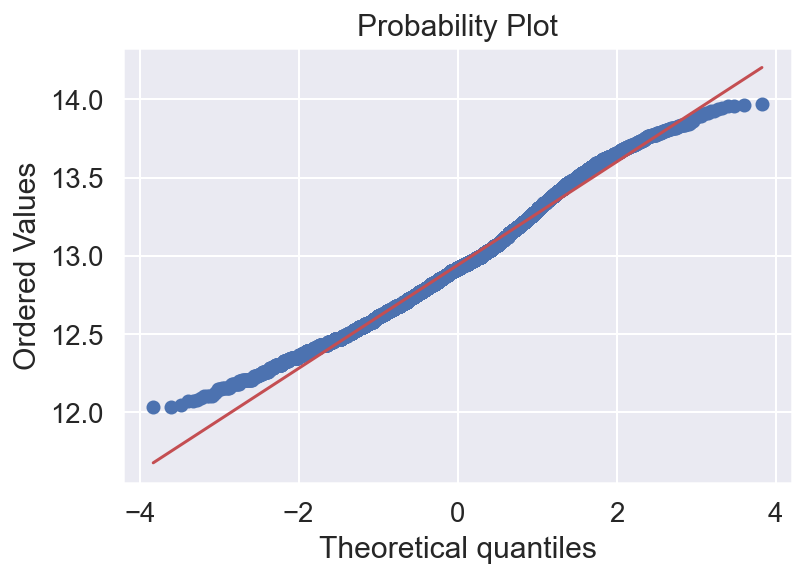

Skewness: 0.345595
Kurtosis: -0.252281


In [374]:
# We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
train["resale_price"] = np.log1p(train["resale_price"])

#Check the new distribution 
sns.distplot(train['resale_price'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['resale_price'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('resale_price distribution')

fig = plt.figure()
res = stats.probplot(train['resale_price'], plot=plt)
plt.show()

y_train = train.resale_price.values

print("Skewness: %f" % train['resale_price'].skew())
print("Kurtosis: %f" % train['resale_price'].kurt())

In [375]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'Skewed Features' :skewed_feats})
skewness.head()

,Skewed Features
storey_range,1.620587
floor_area_sqm,0.242359
remaining_years,-0.068734
Month,-0.099727


In [377]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    all_data[feat] = boxcox1p(all_data[feat], lam)
    all_data[feat] += 1

There are 4 skewed numerical features to Box Cox transform


In [378]:
all_data = pd.get_dummies(all_data)
print(all_data.shape)

(21561, 571)


In [379]:
train = all_data[:ntrain]
test = all_data[ntrain:]

In [380]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

In [381]:
# Cross-validation with k-folds
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [382]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)
model_xgb = xgb.XGBRegressor(colsample_bytree=0.2, gamma=0.0, 
                             learning_rate=0.05, max_depth=6, 
                             min_child_weight=1.5, n_estimators=7200,
                             reg_alpha=0.9, reg_lambda=0.6,
                             subsample=0.2,seed=42, silent=1,
                             random_state =7)
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

In [383]:
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = rmsle_cv(model_lgb)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))


Lasso score: 0.1666 (0.0022)

ElasticNet score: 0.1627 (0.0021)

Kernel Ridge score: 0.1720 (0.0019)

Gradient Boosting score: 0.1259 (0.0032)

Xgboost score: 0.1153 (0.0015)

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ign

In [387]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)

In [388]:
averaged_models = AveragingModels(models = (ENet, GBoost, KRR, lasso))

score = rmsle_cv(averaged_models)
print("Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Averaged base models score: 0.1494 (0.0020)



In [389]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, clf in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(clf)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

In [390]:
stacked_averaged_models = StackingAveragedModels(base_models = (ENet, GBoost, KRR),
                                                 meta_model = model_xgb)

score = rmsle_cv(stacked_averaged_models)
print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

Stacking Averaged models score: 0.1404 (0.0036)


In [391]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [392]:
stacked_averaged_models.fit(train.values, y_train)
stacked_train_pred = stacked_averaged_models.predict(train.values)
stacked_pred = np.expm1(stacked_averaged_models.predict(test.values))
print(rmsle(y_train, stacked_train_pred))

0.12021037625982622


In [393]:
model_xgb.fit(train, y_train)
xgb_train_pred = model_xgb.predict(train)
xgb_pred = np.expm1(model_xgb.predict(test))
print(rmsle(y_train, xgb_train_pred))

0.09447700086829167


In [394]:
model_lgb.fit(train, y_train)
lgb_train_pred = model_lgb.predict(train)
lgb_pred = np.expm1(model_lgb.predict(test.values))
print(rmsle(y_train, lgb_train_pred))

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
0.12977704550154212


In [395]:
print('RMSLE score on train data:')
print(rmsle(y_train,stacked_train_pred*0.70 +
               xgb_train_pred*0.10 + lgb_train_pred*0.20 ))

RMSLE score on train data:
0.11450171621183024


In [396]:
Stacked = 1/(0.1404 )
XGBoost = 1/(0.1153 )
LGBM = 1/(0.1368 )
Sum = Stacked + XGBoost + LGBM
Stacked = Stacked/Sum
XGBoost = XGBoost/Sum
LGBM = LGBM/Sum
print(Stacked, XGBoost, LGBM)

0.3082605728437449 0.37536673397451675 0.3163726931817382


In [397]:
print('RMSLE score on train data:')
print(rmsle(y_train,stacked_train_pred*Stacked +
               xgb_train_pred*XGBoost + lgb_train_pred*LGBM))

RMSLE score on train data:
0.10695065464527391


In [398]:
ensemble = stacked_pred*Stacked + xgb_pred*XGBoost + lgb_pred*LGBM

In [399]:
ensemble

array([266533.69179236, 381136.59816417, 433353.81830364, ...,
       532522.02123127, 276564.62064876, 307112.60911845])

In [428]:
sub = pd.DataFrame()
sub = x_test
# sub['Id'] = test_ID
sub['predicted_resale_Price'] = ensemble
sub['Assigned_resale_price']=x_test['resale_price']
sub['Predicted_Assigned_%_Diff'] = (abs(sub['Assigned_resale_price']-sub['predicted_resale_Price'])/sub['Assigned_resale_price'])*100
sub

,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,resale_price,Year,Month,remaining_years,flat_type_model,Id,predicted_resale_Price,Assigned_resale_price,Predicted_Assigned_%_Diff
37540,JURONG EAST,3 ROOM,261,JURONG EAST ST 24,01 TO 03,67.0,New Generation,220000.0,2018,10,35,3 ROOM New Generation,0,266533.691792,220000.0,21.151678
36309,SERANGOON,4 ROOM,111,SERANGOON NTH AVE 1,10 TO 12,91.0,New Generation,335000.0,2018,9,33,4 ROOM New Generation,1,381136.598164,335000.0,13.772119
37889,PUNGGOL,4 ROOM,617B,PUNGGOL DR,04 TO 06,93.0,Premium Apartment,455000.0,2018,10,5,4 ROOM Premium Apartment,2,433353.818304,455000.0,4.757403
40770,BEDOK,4 ROOM,718,BEDOK RESERVOIR RD,01 TO 03,104.0,Model A,450000.0,2018,12,34,4 ROOM Model A,3,398358.572709,450000.0,11.475873
37615,JURONG WEST,4 ROOM,259,BOON LAY DR,10 TO 12,111.0,Model A,408000.0,2018,10,23,4 ROOM Model A,4,367636.815486,408000.0,9.892937
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23569,JURONG WEST,4 ROOM,182,YUNG SHENG RD,07 TO 09,96.0,Model A,345000.0,2018,3,17,4 ROOM Model A,10776,415049.447144,345000.0,20.304188
30832,CHOA CHU KANG,4 ROOM,691B,CHOA CHU KANG CRES,07 TO 09,91.0,Model A,317000.0,2018,7,15,4 ROOM Model A,10777,321604.773960,317000.0,1.452610
23137,BUKIT MERAH,5 ROOM,85,TELOK BLANGAH HTS,10 TO 12,110.0,Improved,725000.0,2018,3,15,5 ROOM Improved,10778,532522.021231,725000.0,26.548687
20688,BUKIT MERAH,3 ROOM,36,BEO CRES,04 TO 06,59.0,Standard,328000.0,2018,1,47,3 ROOM Standard,10779,276564.620649,328000.0,15.681518


In [429]:
sub['Predicted_Assigned_%_Diff'].mean()

8.511678054165717

In [431]:
sub['Year']

37540    2018
36309    2018
37889    2018
40770    2018
37615    2018
         ... 
23569    2018
30832    2018
23137    2018
20688    2018
32846    2018
Name: Year, Length: 10781, dtype: int64